In [93]:
import numpy as np
from matplotlib import pylab as plt

In [94]:
import pandas as pd

df = pd.read_csv("https://astro.uchicago.edu/~andrey/classes/a205/data/kepler_data.txt", sep="\t", index_col=[0])

df

,P,Rp,SNR,rhostar,Rs,CDPP6,planet,system
0,3.487688,5.82,350.0,0.57,1.65,58.043,46.01,46.0
1,6.029807,1.22,11.5,0.67,1.65,58.043,46.02,46.0
2,0.837491,1.48,188.7,1.21,1.08,22.879,72.01,72.0
3,45.294216,2.33,134.7,1.26,1.08,22.879,72.02,72.0
4,84.687651,2.95,95.1,0.75,1.57,22.190,89.01,89.0
...,...,...,...,...,...,...,...,...
1758,91.940206,2.58,34.4,1.06,1.18,69.414,351.04,351.0
1759,8.719843,1.50,22.7,1.21,1.18,69.414,351.05,351.0
1760,7.008218,1.27,19.2,1.06,1.18,69.414,351.06,351.0
1761,124.922516,3.31,24.4,0.04,1.18,69.414,351.07,351.0


In [95]:


class PlanetarySystem:
    
    def __init__(self, system, period, prad, strad, rhostar, SNR, CDPP6, planet):
        self.system = system
        self.period = period
        self.prad = prad
        self.strad = strad
        self.rhostar = rhostar
        self.SNR = SNR
        self.CDPP6 = CDPP6
        self.planet = planet
        self.snr = self.snr()
        self.snr_cut()
        
            
            
            
    def snr(self):
        areafrac = ((self.prad * 6.371e6) / (self.strad * 696.34e6))**2
    
        # T in hrs, eq. 2 in Weiss et al. 2018
        T = 13. * (self.period/365.)**0.33 * (self.rhostar / 1.41)**(-0.33)

        # Compute SNR
        num = areafrac * np.sqrt(3.5/(p/365.))
        den = (self.CDPP6 /1e6) * np.sqrt(6. / T)

        snr = num / den
        return snr


    
    def snr_cut(self, snr_thresh=10):
        cut = self.snr > snr_thresh
        self.period_cut = self.period[cut]
        self.prad_cut = self.prad[cut]
        self.strad_cut = self.strad[cut]
        self.rhostar_cut = self.rhostar[cut]
        self.CDPP6_cut = self.CDPP6[cut]
        self.planet_cut = self.planet[cut]
        self.snr_cut = self.SNR[cut]
 
    
    

In [96]:
total_PS =[]
for system in df.system.unique():
    slc = df[df.system==system]
    p     = slc["P"]
    rp    = slc["Rp"]
    rs    = slc["Rs"]
    rhos  = slc["rhostar"]
    CDPP6 = slc["CDPP6"]
    SNR = slc["SNR"] 
    planet = slc["planet"]
    PS = PlanetarySystem(df.system, p, rp, rs, rhos, SNR, CDPP6, planet)
    total_PS.append(PS)

In [97]:
from scipy.stats import pearsonr


class Galaxy:
    def __init__(self, total_PS):
        self.rj = np.array([])
        self.rj1 = np.array([])
        self.total_PS = total_PS
        self.corrl_co = 0
        self.pval = 0
        
    def vectors(self):
        '''Function to calculate Rj and Rj+1 for galaxy
        
        Returns Rj and Rj+1
        '''
        for system in self.total_PS:
            periods = np.array(system.period_cut)
            radii = np.array(system.prad_cut)
            
            if len(periods) > 1:
                isort = np.argsort(periods)
                sorted_radii = radii[isort]
        
                self.rj = np.append(self.rj, sorted_radii[:-1])
                self.rj1 = np.append(self.rj1, sorted_radii[1:])

    
    def correlation_coeff(self):
        '''Calculates sample correlation coefficient
        
        x1, x2 are lists of values; their lengths, 
        means, variances, and std deviations are calculated
        
        Returns correlation coefficient'''
        self.corrl_co, self.pval = pearsonr(self.rj, self.rj1)

        
    def bootstrap_unc(self, ns = 1000):
        '''Calculates ns bootstrap samples for samples rj and rj+1'''
        nx = self.rj.size
        ir = np.random.randint(nx, size=nx*ns)
        xbs, ybs = self.rj[ir].reshape(ns, nx), self.rj1[ir].reshape(ns,nx)
        self.rbs = np.zeros(ns)
        for i in range(ns):
            mx, my = np.mean(xbs[i]), np.mean(ybs[i]) 
            self.rbs[i] = np.sum((xbs[i]-mx)*(ybs[i]-my)) / (np.sum((xbs[i]-mx)**2)*np.sum((ybs[i]-my)**2))**0.5
        self.rmean, self.rstd = np.mean(self.rbs), np.std(self.rbs, ddof=1)

0.46258867759198696 7.184876174621253e-48


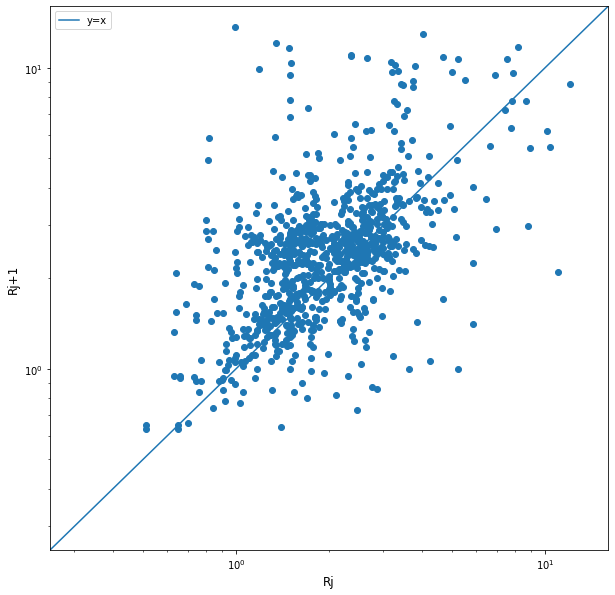

In [98]:
galaxy = Galaxy(total_PS)
galaxy.vectors()
plt.figure(figsize=(10,10))
plt.scatter(galaxy.rj, galaxy.rj1)
plt.xlabel('Rj', fontsize=12)
plt.ylabel('Rj+1', fontsize=12)
plt.yscale("log")
plt.xscale("log")
plt.ylim(0.25, 16)
plt.xlim(0.25,16)
plt.plot([0,2,4,16],[0,2,4,16], label='y=x')
plt.legend()

galaxy.correlation_coeff()
print(galaxy.corrl_co, galaxy.pval)
plt.show()

In [99]:
import copy
import random as ran
total_PS_ = copy.deepcopy(total_PS)
galaxies = []

def galaxy_boot(radii_list, ns=1000, cut=False):
        '''Creates mock galaxy from bootstrap method and find correlation 
        coefficiants and p-values'''
        nx = radii_list.size
        ir = np.random.randint(nx, size=nx*ns)
        
        correlation_list = []
        p_list = []
        for i in range(ns):
            galaxy_rj = []
            galaxy_rj1 = []
            for system in total_PS_:
                radiis = []
                if cut:
                    val = system.prad_cut
                else:
                    val = system.prad
                for j in range(len(val)):
                    radiis.append(radii_list[np.random.choice(ir)])
                if len(radiis) > 1:
                    galaxy_rj = np.append(galaxy_rj, radiis[:-1])
                    galaxy_rj1 = np.append(galaxy_rj1, radiis[1:])
            corrl_co, pval = pearsonr(galaxy_rj, galaxy_rj1)
            correlation_list.append(corrl_co)
            p_list.append(pval)
                
        return correlation_list, p_list

gal_pradii = np.array([])
gal_pradii_cut = np.array([])
for system in total_PS_: 
    gal_pradii_cut = np.append(gal_pradii, system.prad_cut)
for system in total_PS_: 
    gal_pradii = np.append(gal_pradii, system.prad)
correlation_list, p_list = galaxy_boot(gal_pradii, cut=False)
correlation_list_cut, p_list_cut = galaxy_boot(gal_pradii_cut, cut=True)

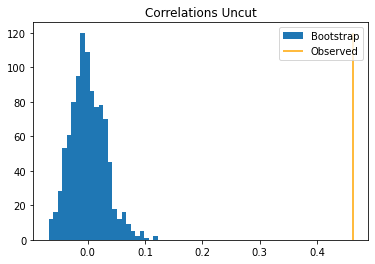

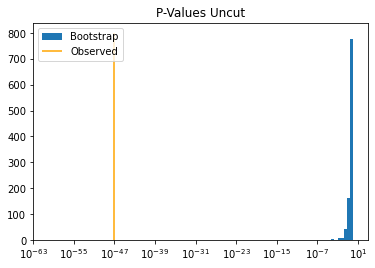

In [100]:
def plot_corrl(values, Title):
        plt.hist(values, bins = 'auto', label= 'Bootstrap')
        plt.vlines(galaxy.corrl_co, 0, 120, color='orange', label='Observed')
        plt.title(Title)
        plt.legend()
        plt.show()
        
        
plot_corrl(correlation_list, 'Correlations Uncut')

def plot_pvals(values, Title):
        x = np.geomspace(10**-60, 1, 100)
        plt.hist(values, bins = x, label='Bootstrap')
        plt.vlines(galaxy.pval,0, 800, color='orange', label='Observed')
        plt.xscale("log")
        plt.title(Title)
        plt.legend()
        plt.show

plot_pvals(p_list, 'P-Values Uncut')

Standard deviation of correlation coefficients: 0.030119828149526746


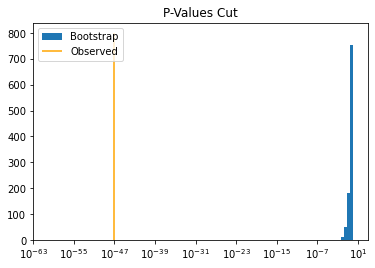

In [101]:
plot_pvals(p_list_cut, 'P-Values Cut')

std = np.std(correlation_list)
print(f"Standard deviation of correlation coefficients: {std}" )

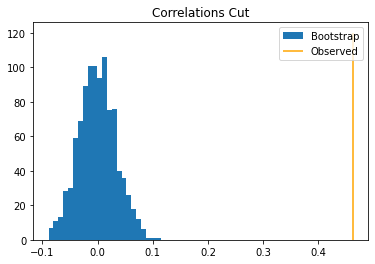

In [102]:
plot_corrl(correlation_list_cut, 'Correlations Cut')

In [103]:
'''The SNR cut and normal values seem to be surprisingly quite similar. The p-values graphs look almost 
exactly the same, but with such small values, the p-values most likely would not have changed much anyway.
The correlation values histogram, however, does seem to have a noticable change. The cut correlation values
are more Gaussian and fit more into a curve, with the regular histogram being a bit more deviated with how
its data flows throughout the graph. This change seems to agree with the research paper, as it appears
the second graph group of correlation coefficients appear smoother and more Gaussian, and the p-values are again
similar to the original data.

'''

'The SNR cut and normal values seem to be surprisingly quite similar. The p-values graphs look almost \nexactly the same, but with such small values, the p-values most likely would not have changed much anyway.\nThe correlation values histogram, however, does seem to have a noticable change. The cut correlation values\nare more Gaussian and fit more into a curve, with the regular histogram being a bit more deviated with how\nits data flows throughout the graph. This change seems to agree with the research paper, as it appears\nthe second graph group of correlation coefficients appear smoother and more Gaussian, and the p-values are again\nsimilar to the original data.\n\n'